In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

In [3]:
random_seed = 8 # 69, 88
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 2

number of all smiles:  642

number of successfully processed smiles:  642


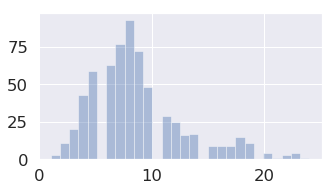

In [4]:
task_name = 'hydration free energy'
tasks = ['expt']

raw_filename = "../data/SAMPL.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [5]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
print("not processed items")
uncovered_df

N

S

C

feature dicts file saved as ../data/SAMPL.pickle

not processed items


,iupac,smiles,expt,calc,cano_smiles
61,ammonia,N,-4.29,-4.018,N
195,hydrogen sulfide,S,-0.70,-1.135,S
286,methane,C,2.00,2.446,C


In [6]:
remained_df = remained_df.reset_index(drop=True)
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(len(test_df),sorted(test_df.cano_smiles.values))


In [7]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

863604

atom_fc.weight torch.Size([200, 39])

atom_fc.bias torch.Size([200])

neighbor_fc.weight torch.Size([200, 49])

neighbor_fc.bias torch.Size([200])

GRUCell.0.weight_ih torch.Size([600, 200])

GRUCell.0.weight_hh torch.Size([600, 200])

GRUCell.0.bias_ih torch.Size([600])

GRUCell.0.bias_hh torch.Size([600])

GRUCell.1.weight_ih torch.Size([600, 200])

GRUCell.1.weight_hh torch.Size([600, 200])

GRUCell.1.bias_ih torch.Size([600])

GRUCell.1.bias_hh torch.Size([600])

align.0.weight torch.Size([1, 400])

align.0.bias torch.Size([1])

align.1.weight torch.Size([1, 400])

align.1.bias torch.Size([1])

attend.0.weight torch.Size([200, 200])

attend.0.bias torch.Size([200])

attend.1.weight torch.Size([200, 200])

attend.1.bias torch.Size([200])

mol_GRUCell.weight_ih torch.Size([600, 200])

mol_GRUCell.weight_hh torch.Size([600, 200])

mol_GRUCell.bias_ih torch.Size([600])

mol_GRUCell.bias_hh torch.Size([600])

mol_align.weight torch.Size([1, 400])

mol_align.bias torch.Size([1])


In [8]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()


In [9]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["valid_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
#     tensorboard.add_scalars('MAE',{'train_MAE':valid_MAE, 'test_MAE':valid_MSE}, epoch)
#     tensorboard.add_scalars('MSE',{'train_MSE':valid_MAE, 'test_MSE':valid_MSE}, epoch)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if valid_MSE < best_param["valid_MSE"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE"] = valid_MSE
        if valid_MSE < 0.8:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >8) and (epoch - best_param["valid_epoch"] >18):        
        break
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    
    train(model, train_df, optimizer, loss_function)


0 5.4889116 4.6295986

1 3.4889457 3.3459234

2 3.4868627 3.1838691

3 3.4330826 3.3401072

4 3.2898693 2.9853556

5 3.1701777 2.8678808

6 3.0564284 2.7971344

7 2.8336735 2.4655533

8 2.4719226 2.2088935

9 2.287127 2.0497832

10 2.2077966 2.018041

11 2.0893774 1.9935333

12 1.8485503 1.7601727

13 1.6490041 1.6649685

14 1.5777755 1.6284981

15 1.4293296 1.4772525

16 1.327753 1.3336158

17 1.3639141 1.382638

18 1.2715518 1.1776

19 1.2102355 1.2026784

20 1.1350868 1.0462834

21 1.1109627 1.0017744

22 1.0982748 1.0629967

23 1.0786741 0.9782093

24 1.096344 1.0988955

25 1.0427724 1.0293592

26 1.0058757 0.9393151

27 1.0150261 0.9684016

28 0.96819484 0.9374981

29 0.9588202 0.9714065

30 0.92903477 0.92668974

31 0.9290548 0.9499346

32 0.91146487 0.9308738

33 0.9080392 0.92374986

34 0.9284361 0.9211718

35 0.9704258 1.0355911

36 0.9314613 1.0441777

37 0.8423892 0.92023414

38 0.8611789 0.9110354

39 0.9563538 0.9655793

40 1.0293821 1.0470486

41 0.8695605 0.8421852

42 0

In [10]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["valid_epoch"],"\n","test RMSE:",np.sqrt(test_MSE))

best epoch: 100 

 test RMSE: 0.7729235
